In [188]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [189]:
path_raw = '/home/matteo@COPPET/Documents/data_science/projects/housing_prices_firenze/data/raw/'

In [190]:
caratteristiche = pd.read_excel(path_raw+'caratteristiche.xlsx')
costi = pd.read_excel(path_raw+'costi.xlsx')
efficienza_energetica = pd.read_excel(path_raw+'efficienza_energetica.xlsx')

In [ ]:
caratteristiche.info()

In [ ]:
costi.info()

In [ ]:
efficienza_energetica.info()

In [191]:
# Drop NaN columns (based on info above, possible error in scraping)
caratteristiche = caratteristiche.drop(columns=['unità', 'Data di inizio lavori e di consegna prevista', 'Dati catastali'])
costi = costi.iloc[:, :3]
efficienza_energetica = efficienza_energetica.iloc[:, :8]

## 1. Data cleaning

### Join all three tables and start looking into the data

In [256]:
# Join tables
df = caratteristiche.join(costi).join(efficienza_energetica)

In [253]:
df['Superficie'].unique()[:-20]

array(['58 m²', '65 m²', '54 m²', ...,
       '230 m² | commerciale 363 m²                 - Vedi dettaglio',
       '230 m² | commerciale 290 m²                 - Vedi dettaglio',
       '90 m² | commerciale 148 m²                 - Vedi dettaglio'],
      dtype=object)

In [ ]:
df.loc[df['prezzo'] == 'Prezzo su richiesta', :].shape

In [ ]:
df.info()

In [257]:
# Rename columns
df.columns = map(str.capitalize, df.columns)

In [258]:
# Remove rentals
df = df.loc[df['Contratto'] != 'Affitto', :]

# Checking for and removing duplicates
df.duplicated().sum()
df = df.drop_duplicates()

In [237]:
df['Indirizzo'] = df['Indirizzo'].str.replace("[",'').str.replace("]",'').str.replace('\'', '')

In [203]:
# Not in Firenze
df = df.drop(index=[1279, 4985])

In [204]:
# Manually impute missing "Zona"
df.loc[df['Indirizzo'] == 'Firenze, via vittorio emanuele orlando', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via borgo la noce', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, via Cigoli 31', 'Zona'] = 'L Isolotto'
df.loc[df['Indirizzo'] == 'Firenze, via impruneta per mezzomonte', 'Zona'] = 'Bellosguardo Galluzzo'
df.loc[df['Indirizzo'] == 'Firenze, via gioberti', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via dei cioli 50', 'Zona'] = 'Settignano Rovezzano'
df.loc[df['Indirizzo'] == 'Firenze, via spinucci 1', 'Zona'] = 'Serpiolle Careggi'
df.loc[df['Indirizzo'] == 'Firenze, "via lungo laffrico 50"', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via lippi', 'Zona'] = 'Legnaia Soffiano'
df.loc[df['Indirizzo'] == 'Firenze, cairoli', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via aretina', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via Fra Bartolommeo  40', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, viale don minzoni 1', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, viale don minzoni  1', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, piazza beccaria', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via san zanobi', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Piazzale Michelangelo', 'Zona'] = 'Michelangelo Porta Romana'
df.loc[df['Indirizzo'] == 'Firenze, Via del Paradiso', 'Zona'] = 'Zona Firenze Sud'
df.loc[df['Indirizzo'] == 'Firenze, via di Canonica', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Via di Canonica', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Via Frusa', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, Via Vespucci', 'Zona'] = 'Firenze Nord'
df.loc[df['Indirizzo'] == 'Firenze, via baracca  148', 'Zona'] = 'Firenze Nord'
df.loc[df['Indirizzo'] == 'Firenze, via dei Tavolini 1', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, via Pisana 980', 'Zona'] = 'Ugnano Mantignano'
df.loc[df['Indirizzo'] == 'Firenze, VIA SENESE', 'Zona'] = 'Bellosguardo Galluzzo'
df.loc[df['Indirizzo'] == 'Firenze, "piazza dAzeglio"', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, "Piazza dazeglio"', 'Zona'] = 'Centro'

In [205]:
df['Zona'] = df['Zona'].fillna('Non specificato')

In [240]:
df['Zona'] = (df['Zona']
              .str.replace('-', ' ')
              .str.replace('/', '')
              .str.title())

In [242]:
# Clean up data types
df['Superficie [m2]'] = (df['Superficie']
                         .str.split('m²')
                         .str[0]
                         .astype('float'))

df['Totale piani edificio'] = (df['Totale piani edificio']
                               .str.split(' ')
                               .str[0]
                               .astype('float'))

df['Zona'] = (df['Zona']
              .str.replace('-', ' ')
              .str.replace('/', '')
              .str.title())

df['Prezzo [EUR]'] = (df['Prezzo']
                      .str.split('€')
                      .str[1]
                      .str.replace('.', '')
                      .astype('float'))

In [315]:
# Extract area
df['Superficie [m2]'] = (df['Superficie']
                         .str.split('|')
                         .str[1]
                         .str.extract(r'(\d+\.?\d*)'))
df['Superficie [m2]'] = (df['Superficie [m2]']
                         .fillna(df['Superficie']
                         .str.split('|')
                         .str[0]
                         .str.extract(r'(\d+\.?\d*)')))
#df['Superficie [m2]'] = (df['Superficie [m2]']
#                         .str.replace('.', '')
#                         .astype('float'))

TypeError: "value" parameter must be a scalar, dict or Series, but you passed a "DataFrame"

In [311]:
df['Superficie [m2]'].head(20)

0      [58]
1      [65]
2      [54]
3      [56]
4      [85]
5      [46]
6      [50]
7     [112]
8       121
9      [40]
10     [60]
11    [142]
12       84
13    [212]
14     [50]
15    [110]
16    [120]
17     [42]
18      114
19       75
Name: Superficie [m2], dtype: object

In [ ]:
df['Prezzo [EUR]'].mean()

In [199]:
# Drop entries without area
df = df.dropna(subset=['Superficie [m2]'])

In [ ]:
# Looking into "Contratto": does it affect price?
gb = df['Prezzo [EUR]'].groupby(df['Contratto']).agg('mean')
gb

In [ ]:
# Drop columns that have almost no entries
# Dropping because of lack of entries
# Dropping "Disponibilità" and "Contratto" because it is not relevant information
df = df.drop(columns=['Immobile garantito', 'Indice prest. energetica rinnovabile',
                      'Prestazione energetica del fabbricato', 'Certificazione energetica',
                      'Disponibilità', 'Contratto'])


In [ ]:
df.info()

### Feature engineering

#### Heating

In [41]:
df['Riscaldamento'].isna().sum()

417

In [207]:
# Create type of heating feature
df['Tipologia di riscaldamento'] = df['Riscaldamento'].str.split(',').str[0]

#### Listing date

In [ ]:
df['Riferimento e data annuncio'].head(100)

In [208]:
df['Data annuncio'] = (df['Riferimento e data annuncio']
                       .str.split('-')
                       .str[-1]
                       .str.strip()
                       .astype('datetime64[D]'))

#### Floor

In [ ]:
df['Piano'].unique()

In [209]:
mask = df['Piano'].str.match(r'(.*ascensore.*)')

df['Ascensore'] = mask.astype('float')

In [ ]:
df['Totale piani edificio'].isna().sum()

In [ ]:
df['Altre caratteristiche'].str.replace('\n', ';')
df['Altre caratteristiche'].unique()[10]

In [ ]:
df['Stato'].value_counts()

#### Number of rooms and toilets

In [ ]:
# Create number of rooms feature
pat = r'\(.*\)'
repl = lambda m: m.group(0).replace(',', ';')

df['Locali'] = df['Locali'].str.replace(pat, repl)

In [210]:
# TO FLOAT? 3+
df['Numero di bagni'] = (df['Locali']
                         .str.findall(r'(\d\+? bagn\w)')
                         .str[0]
                         .str.split(' ')
                         .str[0])

df.loc[df['Numero di bagni'].isna(), 'Numero di bagni'] = 0
df.loc[df['Numero di bagni'] == '3+', 'Numero di bagni'] = 4
df['Numero di bagni'] = df['Numero di bagni'].astype('float')

In [ ]:
df['Numero di bagni'].value_counts()

In [ ]:
sns.barplot(x=df['Numero di bagni'].value_counts().index, y=df['Numero di bagni'].value_counts())

In [ ]:
df.loc[df['Numero di bagni'] == 0, 'Superficie [m2]']

In [211]:
df['Superficie_Bins'] = pd.cut(df['Superficie [m2]'], bins=[0, 60, 80, 100, 120, 160, 200, 10000])


In [ ]:
df['Superficie_Bins'].unique()

In [ ]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Superficie_Bins'], y=df['Numero di bagni'])
plt.xticks(rotation=45)

In [ ]:
df.groupby(['Superficie_Bins'])['Numero di bagni'].agg(lambda x:x.value_counts().index[0])

In [212]:
# Imputing number of toilets based on area bins
for area in df['Superficie_Bins'].unique():
    mask = df['Superficie_Bins'] == area
    df.loc[mask & (df['Numero di bagni'] == 0), 'Numero di bagni'] = df.loc[mask, 'Numero di bagni'].mode().values


In [213]:
df['Numero di altri'] = (df['Locali']
                         .str.findall(r'(\d?\d\+? altr\w)')
                         .str[0]
                         .str.split(' ')
                         .str[0]
                         .astype('float'))
df.loc[df['Numero di altri'].isna(), 'Numero di altri'] = 0

In [214]:
df['Numero di camere da letto'] = (df['Locali']
                                   .str.findall(r'(\d?\d\+? camer\w da letto)')
                                   .str[0]
                                   .str.split(' ')
                                   .str[0]
                                   .astype('float'))
df.loc[df['Numero di camere da letto'].isna(), 'Numero di camere da letto'] = 0

In [215]:
df['Numero di locali'] = (df['Locali']
                          .str.findall(r'(\d?\d\+? local\w)')
                          .str[0]
                          .str.split(' ')
                          .str[0]
                          .astype('float'))
df.loc[df['Numero di locali'].isna(), 'Numero di locali'] = 0

In [216]:
df['Numero totale di locali'] = df['Numero di locali'] + df['Numero di camere da letto'] + df['Numero di altri']

In [ ]:
df['Numero totale di locali'].isna().sum()

In [ ]:
df.loc[df['Locali'].isna(), :].shape

In [ ]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Superficie_Bins'], y=df['Numero totale di locali'])
plt.xticks(rotation=45)

In [217]:
# Imputing number of rooms based on area bins
for area in df['Superficie_Bins'].unique():
    mask = df['Superficie_Bins'] == area
    df.loc[mask & (df['Numero totale di locali'] == 0),
           'Numero totale di locali'] = df.loc[mask, 'Numero totale di locali'].mode().values

In [ ]:
df.loc[mask & (df['Numero totale di locali'] == 0), 'Numero totale di locali']

In [ ]:
df.loc[df['Numero totale di locali'].isna(), :].shape

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9038 entries, 0 to 9064
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Immobile garantito                     3802 non-null   object        
 1   Riferimento e data annuncio            9038 non-null   object        
 2   Contratto                              9038 non-null   object        
 3   Tipologia                              9038 non-null   object        
 4   Superficie                             9030 non-null   object        
 5   Locali                                 9022 non-null   object        
 6   Piano                                  8836 non-null   object        
 7   Totale piani edificio                  8333 non-null   float64       
 8   Disponibilità                          8059 non-null   object        
 9   Tipo proprietà                         8556 non-null   object  

In [218]:
df_final = df[['Data annuncio', 'Zona', 'Prezzo [EUR]', 'Tipologia', 'Superficie [m2]',
               'Numero totale di locali', 'Numero di bagni', 'Stato', 'Tipologia di riscaldamento']]

In [219]:
df_final = df_final.dropna(subset=['Prezzo [EUR]'])

In [ ]:
df_final.loc[df_final['Prezzo [EUR]'].isna(), :]

In [43]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8743 entries, 0 to 9062
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Data annuncio               8743 non-null   datetime64[ns]
 1   Zona                        8683 non-null   object        
 2   Prezzo [EUR]                8743 non-null   float64       
 3   Tipologia                   8743 non-null   object        
 4   Superficie [m2]             8743 non-null   float64       
 5   Numero totale di locali     8743 non-null   float64       
 6   Numero di bagni             8743 non-null   float64       
 7   Stato                       8743 non-null   object        
 8   Tipologia di riscaldamento  8743 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 1003.0+ KB


In [ ]:
# Dropping N/A values


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

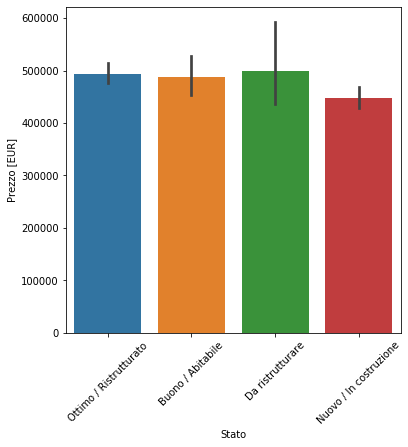

In [35]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df_final['Stato'], y=df_final['Prezzo [EUR]'])
plt.xticks(rotation=45)

In [220]:
# Imputing "Stato" by most frequent as it does not seem to influence price much
df_final['Stato'] = df_final['Stato'].fillna(df_final['Stato'].value_counts().index[0])

(array([0, 1]), <a list of 2 Text xticklabel objects>)

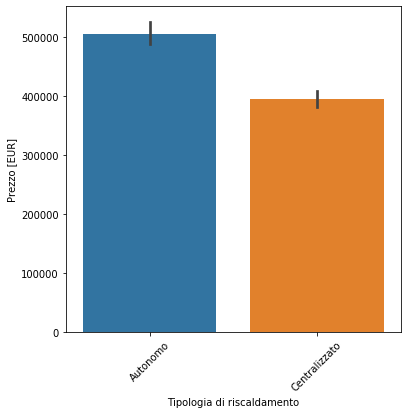

In [36]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df_final['Tipologia di riscaldamento'], y=df_final['Prezzo [EUR]'])
plt.xticks(rotation=45)

In [39]:
df_final['Tipologia di riscaldamento'].value_counts()

Autonomo         6512
Centralizzato    1834
Name: Tipologia di riscaldamento, dtype: int64

In [221]:
# Filling heating NaNs with centralized as if not specified it is probably centralized
df_final['Tipologia di riscaldamento'] = df_final['Tipologia di riscaldamento'].fillna('Centralizzato')

In [168]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8749 entries, 0 to 9062
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Data annuncio               8749 non-null   datetime64[ns]
 1   Zona                        8749 non-null   object        
 2   Prezzo [EUR]                8749 non-null   float64       
 3   Tipologia                   8749 non-null   object        
 4   Superficie [m2]             8742 non-null   float64       
 5   Numero totale di locali     8749 non-null   float64       
 6   Numero di bagni             8749 non-null   float64       
 7   Stato                       8749 non-null   object        
 8   Tipologia di riscaldamento  8749 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 683.5+ KB


In [180]:
df_final.loc[df_final['Superficie [m2]'].isna(), :]

,Data annuncio,Zona,Prezzo [EUR],Tipologia,Superficie [m2],Numero totale di locali,Numero di bagni,Stato,Tipologia di riscaldamento
1279,2020-09-18,Firenze Nord,240000.0,Appartamento,NaN,0.0,0.0,Ottimo / Ristrutturato,Centralizzato


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

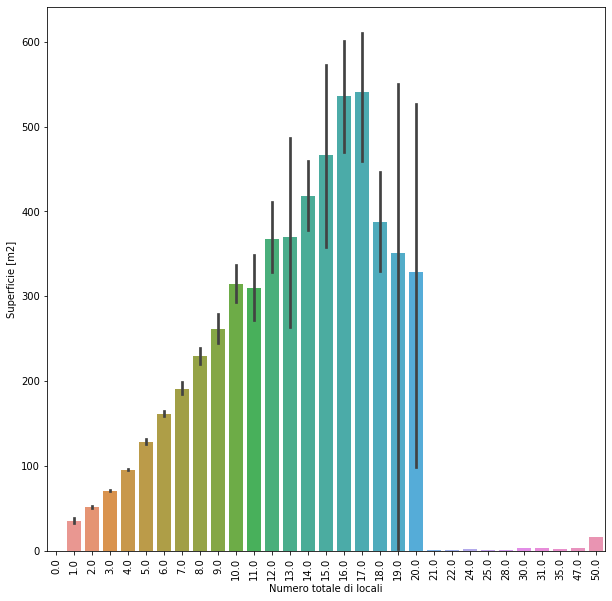

In [172]:
fig = plt.figure(figsize=(10, 10))
sns.barplot(x=df_final['Numero totale di locali'], y=df_final['Superficie [m2]'])
plt.xticks(rotation=90)

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 <a list of 11 Text xticklabel objects>)

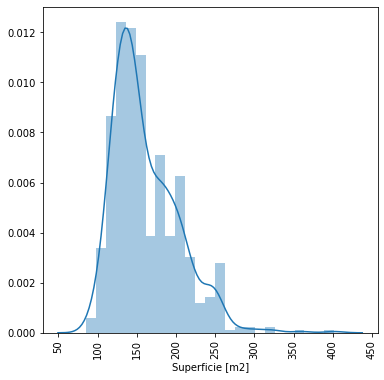

In [177]:
fig = plt.figure(figsize=(6, 6))
sns.distplot(df_final.loc[df_final['Numero totale di locali'] == 6, 'Superficie [m2]'])
plt.xticks(rotation=90)

In [222]:
# Imputing area based on total number of rooms
for rooms in df_final['Numero totale di locali'].unique():
    mask = df_final['Numero totale di locali'] == rooms
    df_final.loc[mask & (df_final['Superficie [m2]'].isna()),
                 'Superficie [m2]'] = df_final.loc[mask, 'Superficie [m2]'].mean()

In [181]:
df_final['Numero totale di locali'].unique()

array([ 2.,  3.,  4.,  5.,  8., 10.,  6.,  9.,  1.,  7., 13., 11., 17.,
       12., 18.,  0., 14., 28., 20., 16., 19., 30., 35., 15., 47., 31.,
       25., 21., 24., 22., 50.])

In [223]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8748 entries, 0 to 9062
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Data annuncio               8748 non-null   datetime64[ns]
 1   Zona                        8748 non-null   object        
 2   Prezzo [EUR]                8748 non-null   float64       
 3   Tipologia                   8748 non-null   object        
 4   Superficie [m2]             8748 non-null   float64       
 5   Numero totale di locali     8748 non-null   float64       
 6   Numero di bagni             8748 non-null   float64       
 7   Stato                       8748 non-null   object        
 8   Tipologia di riscaldamento  8748 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 683.4+ KB


## 2. Exploratory Data Analysis

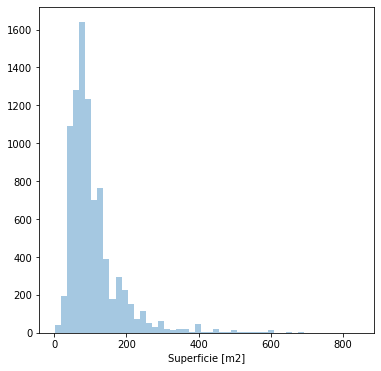

In [224]:
# Area [m2] distribution
fig = plt.figure(figsize=(6, 6))
sns.distplot(df_final['Superficie [m2]'], kde=False)

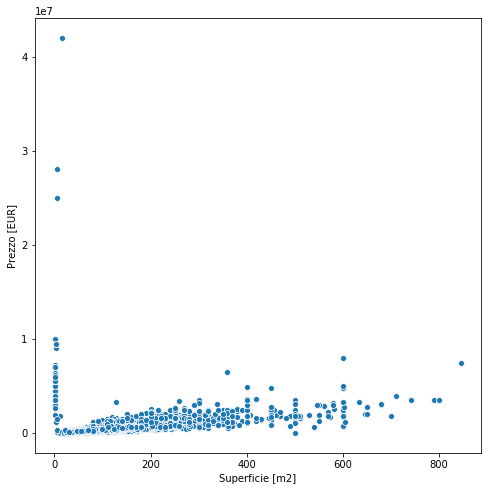

In [226]:
fig = plt.figure(figsize=(8, 8))
sns.scatterplot(x='Superficie [m2]', y='Prezzo [EUR]', data=df_final)

In [230]:
df_final.loc[df_final['Prezzo [EUR]'].idxmax(), :]

Data annuncio                    2020-08-31 00:00:00
Zona                          Zona Bolognese Le Cure
Prezzo [EUR]                                 4.2e+07
Tipologia                                    Cascina
Superficie [m2]                                   16
Numero totale di locali                           50
Numero di bagni                                    4
Stato                              Buono / Abitabile
Tipologia di riscaldamento                  Autonomo
Name: 9049, dtype: object